In [1]:
import dask.diagnostics
import faceted
import numpy as np
import xarray as xr

from upath import UPath

import plotting
import utils

In [2]:
plotting.configure_style()

In [3]:
REFERENCE_ROOT = UPath(
    "gs://vcm-ml-raw-flexible-retention/2024-07-03-C96-SHiELD-SOM/regridded-zarrs/gaussian_grid_180_by_360/radiation-multi-call"
)
BASELINE_ROOT = UPath(
    "gs://vcm-ml-raw-flexible-retention/2024-11-11-C24-SHiELD-SOM-tuned-cdmbgwd/regridded-zarrs/gaussian_grid_45_by_90/radiation-multi-call"
)

In [4]:
FACTORS = [0.5, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 8.0, 1.0]
FLUXES = ["DLWRFsfc", "ULWRFsfc", "DSWRFsfc", "USWRFsfc", "ULWRFtoa", "USWRFtoa"]

In [5]:
def unpack_multi_call_diagnostics(ds, factors):
    datasets = {}
    for index, factor in enumerate(factors, start=1):
        fluxes_for_factor = []
        for flux in FLUXES:
            name = f"{flux}_with_scaled_co2_{index}"
            fluxes_for_factor.append(ds[name].rename(flux))
        datasets[factor] = xr.merge(fluxes_for_factor)
    return utils.dict_to_dataset(datasets, dim="factor").sortby("factor")


def open_multi_call_diagnostics(root, factors):
    multi_call = xr.open_zarr(root / "radiation_multi_call_diagnostics.zarr")
    base = xr.open_zarr(root / "fluxes_2d.zarr")

    base_as_multi_call = []
    for flux in FLUXES:
        renamed = base[flux].rename(f"{flux}_with_scaled_co2_{len(factors)}")
        base_as_multi_call.append(renamed)
    base_as_multi_call = xr.merge(base_as_multi_call)
    ds = xr.merge([multi_call, base_as_multi_call])
    ds = unpack_multi_call_diagnostics(ds, factors)
    time_mean = ds.isel(time=slice(1460, None)).mean("time")
    return time_mean.weighted(np.cos(np.deg2rad(time_mean.grid_yt))).mean(
        ["grid_xt", "grid_yt"]
    )


def open_multi_call_ace_diagnostics(beaker_dataset_id, factors):
    time_mean = utils.open_beaker_dataset(beaker_dataset_id, "time_mean_diagnostics.nc")
    base_as_multi_call = []
    for flux in FLUXES:
        renamed = time_mean[f"gen_map-{flux}"].rename(f"gen_map-{flux}_1.00xCO2")
        base_as_multi_call.append(renamed)

    base_as_multi_call = xr.merge(base_as_multi_call)
    time_mean = time_mean.merge(base_as_multi_call)

    datasets = {}
    for factor in factors:
        fluxes_for_factor = []
        for flux in FLUXES:
            name = f"gen_map-{flux}_{factor:0.2f}xCO2"
            fluxes_for_factor.append(time_mean[name].rename(flux))
        datasets[factor] = xr.merge(fluxes_for_factor)
    result = utils.dict_to_dataset(datasets, dim="factor").sortby("factor")
    return result.weighted(np.cos(np.deg2rad(time_mean.lat))).mean(["lon", "lat"])

In [6]:
REFERENCE = "SHiELD-SOM-C96"
ACE2_SOM = "ACE2-SOM-multi-climate-RS3"
BASELINE = "SHiELD-SOM-C24-tuned-cdmbgwd"

catalog = utils.open_catalog()
cases = catalog[catalog["forcing"] == "radiation-multi-calls"]
ace_datasets = {}
for _, case in cases.iterrows():
    model = case["model"]
    beaker_id = case["beaker_id"]
    ace_datasets[model] = open_multi_call_ace_diagnostics(beaker_id, FACTORS)
ace_ds = utils.dict_to_dataset(ace_datasets, "model")

reference = open_multi_call_diagnostics(REFERENCE_ROOT, FACTORS).assign_coords(
    model=REFERENCE
)
baseline = open_multi_call_diagnostics(BASELINE_ROOT, FACTORS).assign_coords(
    model=BASELINE
)

combined = xr.concat([reference, baseline, ace_ds], dim="model")

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [7]:
with dask.diagnostics.ProgressBar():
    combined = combined.compute()

[                                        ] | 0% Completed | 364.78 us

[                                        ] | 0% Completed | 113.28 ms

[                                        ] | 0% Completed | 214.62 ms

[                                        ] | 0% Completed | 316.55 ms

[                                        ] | 0% Completed | 418.14 ms

[                                        ] | 0% Completed | 519.90 ms

[                                        ] | 0% Completed | 621.70 ms

[                                        ] | 0% Completed | 723.47 ms

[                                        ] | 0% Completed | 825.43 ms

[                                        ] | 0% Completed | 926.93 ms

[                                        ] | 0% Completed | 1.03 s

[                                        ] | 0% Completed | 1.13 s

[                                        ] | 0% Completed | 1.23 s

[                                        ] | 0% Completed | 1.33 s

[                                        ] | 0% Completed | 1.44 s

[                                        ] | 0% Completed | 1.54 s

[                                        ] | 0% Completed | 1.64 s

[                                        ] | 0% Completed | 1.74 s

[                                        ] | 0% Completed | 1.84 s

[                                        ] | 0% Completed | 1.95 s

[                                        ] | 0% Completed | 2.05 s

[                                        ] | 0% Completed | 2.15 s

[                                        ] | 0% Completed | 2.26 s

[                                        ] | 0% Completed | 2.36 s

[                                        ] | 0% Completed | 2.46 s

[                                        ] | 0% Completed | 2.57 s

[                                        ] | 1% Completed | 2.67 s

[                                        ] | 1% Completed | 2.77 s

[                                        ] | 1% Completed | 2.87 s

[                                        ] | 1% Completed | 2.98 s

[                                        ] | 1% Completed | 3.08 s

[                                        ] | 1% Completed | 3.18 s

[                                        ] | 1% Completed | 3.29 s

[                                        ] | 1% Completed | 3.39 s

[                                        ] | 1% Completed | 3.49 s

[                                        ] | 1% Completed | 3.59 s

[                                        ] | 1% Completed | 3.69 s

[                                        ] | 1% Completed | 3.80 s

[                                        ] | 1% Completed | 3.90 s

[                                        ] | 1% Completed | 4.00 s

[                                        ] | 1% Completed | 4.10 s

[                                        ] | 1% Completed | 4.20 s

[                                        ] | 1% Completed | 4.31 s

[                                        ] | 1% Completed | 4.41 s

[                                        ] | 1% Completed | 4.51 s

[                                        ] | 1% Completed | 4.61 s

[                                        ] | 2% Completed | 4.72 s

[                                        ] | 2% Completed | 4.82 s

[                                        ] | 2% Completed | 4.92 s

[                                        ] | 2% Completed | 5.03 s

[                                        ] | 2% Completed | 5.13 s

[                                        ] | 2% Completed | 5.23 s

[                                        ] | 2% Completed | 5.33 s

[                                        ] | 2% Completed | 5.43 s

[#                                       ] | 2% Completed | 5.54 s

[#                                       ] | 2% Completed | 5.64 s

[#                                       ] | 2% Completed | 5.74 s

[#                                       ] | 2% Completed | 5.84 s

[#                                       ] | 2% Completed | 5.94 s

[#                                       ] | 2% Completed | 6.04 s

[#                                       ] | 2% Completed | 6.15 s

[#                                       ] | 3% Completed | 6.26 s

[#                                       ] | 3% Completed | 6.36 s

[#                                       ] | 3% Completed | 6.46 s

[#                                       ] | 3% Completed | 6.57 s

[#                                       ] | 3% Completed | 6.67 s

[#                                       ] | 3% Completed | 6.77 s

[#                                       ] | 3% Completed | 6.88 s

[#                                       ] | 3% Completed | 6.98 s

[#                                       ] | 3% Completed | 7.08 s

[#                                       ] | 3% Completed | 7.18 s

[#                                       ] | 3% Completed | 7.29 s

[#                                       ] | 3% Completed | 7.39 s

[#                                       ] | 3% Completed | 7.50 s

[#                                       ] | 3% Completed | 7.60 s

[#                                       ] | 3% Completed | 7.71 s

[#                                       ] | 3% Completed | 7.81 s

[#                                       ] | 3% Completed | 7.91 s

[#                                       ] | 3% Completed | 8.01 s

[#                                       ] | 3% Completed | 8.11 s

[#                                       ] | 4% Completed | 8.22 s

[#                                       ] | 4% Completed | 8.32 s

[#                                       ] | 4% Completed | 8.42 s

[#                                       ] | 4% Completed | 8.52 s

[#                                       ] | 4% Completed | 8.63 s

[#                                       ] | 4% Completed | 8.73 s

[#                                       ] | 4% Completed | 8.83 s

[#                                       ] | 4% Completed | 8.93 s

[#                                       ] | 4% Completed | 9.04 s

[#                                       ] | 4% Completed | 9.14 s

[#                                       ] | 4% Completed | 9.24 s

[#                                       ] | 4% Completed | 9.35 s

[#                                       ] | 4% Completed | 9.45 s

[#                                       ] | 4% Completed | 9.55 s

[#                                       ] | 4% Completed | 9.65 s

[#                                       ] | 4% Completed | 9.76 s

[##                                      ] | 5% Completed | 9.87 s

[##                                      ] | 5% Completed | 9.97 s

[##                                      ] | 5% Completed | 10.07 s

[##                                      ] | 5% Completed | 10.18 s

[##                                      ] | 5% Completed | 10.28 s

[##                                      ] | 5% Completed | 10.38 s

[##                                      ] | 5% Completed | 10.49 s

[##                                      ] | 5% Completed | 10.59 s

[##                                      ] | 5% Completed | 10.69 s

[##                                      ] | 5% Completed | 10.79 s

[##                                      ] | 5% Completed | 10.89 s

[##                                      ] | 5% Completed | 11.00 s

[##                                      ] | 5% Completed | 11.10 s

[##                                      ] | 5% Completed | 11.20 s

[##                                      ] | 5% Completed | 11.30 s

[##                                      ] | 5% Completed | 11.40 s

[##                                      ] | 5% Completed | 11.51 s

[##                                      ] | 5% Completed | 11.61 s

[##                                      ] | 6% Completed | 11.71 s

[##                                      ] | 6% Completed | 11.82 s

[##                                      ] | 6% Completed | 11.92 s

[##                                      ] | 6% Completed | 12.02 s

[##                                      ] | 6% Completed | 12.12 s

[##                                      ] | 6% Completed | 12.23 s

[##                                      ] | 6% Completed | 12.33 s

[##                                      ] | 6% Completed | 12.43 s

[##                                      ] | 6% Completed | 12.53 s

[##                                      ] | 6% Completed | 12.64 s

[##                                      ] | 6% Completed | 12.74 s

[##                                      ] | 6% Completed | 12.84 s

[##                                      ] | 6% Completed | 12.94 s

[##                                      ] | 6% Completed | 13.04 s

[##                                      ] | 6% Completed | 13.14 s

[##                                      ] | 6% Completed | 13.25 s

[##                                      ] | 7% Completed | 13.35 s

[##                                      ] | 7% Completed | 13.45 s

[##                                      ] | 7% Completed | 13.55 s

[##                                      ] | 7% Completed | 13.66 s

[##                                      ] | 7% Completed | 13.76 s

[##                                      ] | 7% Completed | 13.86 s

[##                                      ] | 7% Completed | 13.96 s

[##                                      ] | 7% Completed | 14.06 s

[##                                      ] | 7% Completed | 14.17 s

[##                                      ] | 7% Completed | 14.27 s

[##                                      ] | 7% Completed | 14.37 s

[##                                      ] | 7% Completed | 14.48 s

[###                                     ] | 7% Completed | 14.58 s

[###                                     ] | 7% Completed | 14.68 s

[###                                     ] | 7% Completed | 14.79 s

[###                                     ] | 7% Completed | 14.89 s

[###                                     ] | 7% Completed | 14.99 s

[###                                     ] | 7% Completed | 15.10 s

[###                                     ] | 7% Completed | 15.20 s

[###                                     ] | 8% Completed | 15.30 s

[###                                     ] | 8% Completed | 15.40 s

[###                                     ] | 8% Completed | 15.50 s

[###                                     ] | 8% Completed | 15.61 s

[###                                     ] | 8% Completed | 15.71 s

[###                                     ] | 8% Completed | 15.81 s

[###                                     ] | 8% Completed | 15.91 s

[###                                     ] | 8% Completed | 16.02 s

[###                                     ] | 8% Completed | 16.12 s

[###                                     ] | 8% Completed | 16.22 s

[###                                     ] | 8% Completed | 16.32 s

[###                                     ] | 8% Completed | 16.43 s

[###                                     ] | 8% Completed | 16.53 s

[###                                     ] | 8% Completed | 16.63 s

[###                                     ] | 8% Completed | 16.73 s

[###                                     ] | 8% Completed | 16.84 s

[###                                     ] | 8% Completed | 16.94 s

[###                                     ] | 8% Completed | 17.04 s

[###                                     ] | 9% Completed | 17.14 s

[###                                     ] | 9% Completed | 17.25 s

[###                                     ] | 9% Completed | 17.35 s

[###                                     ] | 9% Completed | 17.45 s

[###                                     ] | 9% Completed | 17.55 s

[###                                     ] | 9% Completed | 17.66 s

[###                                     ] | 9% Completed | 17.76 s

[###                                     ] | 9% Completed | 17.86 s

[###                                     ] | 9% Completed | 17.96 s

[###                                     ] | 9% Completed | 18.06 s

[###                                     ] | 9% Completed | 18.17 s

[###                                     ] | 9% Completed | 18.27 s

[###                                     ] | 9% Completed | 18.37 s

[###                                     ] | 9% Completed | 18.47 s

[###                                     ] | 9% Completed | 18.57 s

[###                                     ] | 9% Completed | 18.68 s

[####                                    ] | 10% Completed | 18.78 s

[####                                    ] | 10% Completed | 18.88 s

[####                                    ] | 10% Completed | 18.98 s

[####                                    ] | 10% Completed | 19.08 s

[####                                    ] | 10% Completed | 19.19 s

[####                                    ] | 10% Completed | 19.29 s

[####                                    ] | 10% Completed | 19.39 s

[####                                    ] | 10% Completed | 19.50 s

[####                                    ] | 10% Completed | 19.60 s

[####                                    ] | 10% Completed | 19.70 s

[####                                    ] | 10% Completed | 19.80 s

[####                                    ] | 10% Completed | 19.91 s

[####                                    ] | 10% Completed | 20.01 s

[####                                    ] | 10% Completed | 20.11 s

[####                                    ] | 10% Completed | 20.21 s

[####                                    ] | 10% Completed | 20.31 s

[####                                    ] | 10% Completed | 20.42 s

[####                                    ] | 10% Completed | 20.52 s

[####                                    ] | 10% Completed | 20.62 s

[####                                    ] | 10% Completed | 20.72 s

[####                                    ] | 11% Completed | 20.82 s

[####                                    ] | 11% Completed | 20.93 s

[####                                    ] | 11% Completed | 21.03 s

[####                                    ] | 11% Completed | 21.13 s

[####                                    ] | 11% Completed | 21.23 s

[####                                    ] | 11% Completed | 21.33 s

[####                                    ] | 11% Completed | 21.44 s

[####                                    ] | 11% Completed | 21.54 s

[####                                    ] | 11% Completed | 21.64 s

[####                                    ] | 11% Completed | 21.75 s

[####                                    ] | 11% Completed | 21.85 s

[####                                    ] | 11% Completed | 21.95 s

[####                                    ] | 11% Completed | 22.05 s

[####                                    ] | 11% Completed | 22.16 s

[####                                    ] | 11% Completed | 22.26 s

[####                                    ] | 11% Completed | 22.36 s

[####                                    ] | 11% Completed | 22.46 s

[####                                    ] | 11% Completed | 22.57 s

[####                                    ] | 11% Completed | 22.67 s

[####                                    ] | 12% Completed | 22.77 s

[####                                    ] | 12% Completed | 22.87 s

[####                                    ] | 12% Completed | 22.97 s

[####                                    ] | 12% Completed | 23.08 s

[####                                    ] | 12% Completed | 23.18 s

[####                                    ] | 12% Completed | 23.28 s

[####                                    ] | 12% Completed | 23.38 s

[#####                                   ] | 12% Completed | 23.49 s

[#####                                   ] | 12% Completed | 23.59 s

[#####                                   ] | 12% Completed | 23.69 s

[#####                                   ] | 12% Completed | 23.79 s

[#####                                   ] | 12% Completed | 23.89 s

[#####                                   ] | 12% Completed | 24.00 s

[#####                                   ] | 12% Completed | 24.10 s

[#####                                   ] | 12% Completed | 24.20 s

[#####                                   ] | 12% Completed | 24.30 s

[#####                                   ] | 12% Completed | 24.40 s

[#####                                   ] | 12% Completed | 24.51 s

[#####                                   ] | 12% Completed | 24.61 s

[#####                                   ] | 12% Completed | 24.71 s

[#####                                   ] | 12% Completed | 24.81 s

[#####                                   ] | 13% Completed | 24.92 s

[#####                                   ] | 13% Completed | 25.02 s

[#####                                   ] | 13% Completed | 25.13 s

[#####                                   ] | 13% Completed | 25.23 s

[#####                                   ] | 13% Completed | 25.33 s

[#####                                   ] | 13% Completed | 25.44 s

[#####                                   ] | 13% Completed | 25.54 s

[#####                                   ] | 13% Completed | 25.64 s

[#####                                   ] | 13% Completed | 25.75 s

[#####                                   ] | 13% Completed | 25.85 s

[#####                                   ] | 13% Completed | 25.95 s

[#####                                   ] | 13% Completed | 26.05 s

[#####                                   ] | 13% Completed | 26.16 s

[#####                                   ] | 13% Completed | 26.26 s

[#####                                   ] | 13% Completed | 26.36 s

[#####                                   ] | 13% Completed | 26.46 s

[#####                                   ] | 13% Completed | 26.57 s

[#####                                   ] | 14% Completed | 26.67 s

[#####                                   ] | 14% Completed | 26.77 s

[#####                                   ] | 14% Completed | 26.87 s

[#####                                   ] | 14% Completed | 26.98 s

[#####                                   ] | 14% Completed | 27.08 s

[#####                                   ] | 14% Completed | 27.18 s

[#####                                   ] | 14% Completed | 27.29 s

[#####                                   ] | 14% Completed | 27.39 s

[#####                                   ] | 14% Completed | 27.49 s

[#####                                   ] | 14% Completed | 27.59 s

[#####                                   ] | 14% Completed | 27.69 s

[#####                                   ] | 14% Completed | 27.80 s

[#####                                   ] | 14% Completed | 27.90 s

[#####                                   ] | 14% Completed | 28.00 s

[#####                                   ] | 14% Completed | 28.10 s

[#####                                   ] | 14% Completed | 28.21 s

[#####                                   ] | 14% Completed | 28.31 s

[#####                                   ] | 14% Completed | 28.41 s

[#####                                   ] | 14% Completed | 28.51 s

[#####                                   ] | 14% Completed | 28.61 s

[#####                                   ] | 14% Completed | 28.72 s

[#####                                   ] | 14% Completed | 28.82 s

[#####                                   ] | 14% Completed | 28.92 s

[#####                                   ] | 14% Completed | 29.02 s

[######                                  ] | 15% Completed | 29.12 s

[######                                  ] | 15% Completed | 29.22 s

[######                                  ] | 15% Completed | 29.33 s

[######                                  ] | 15% Completed | 29.43 s

[######                                  ] | 15% Completed | 29.53 s

[######                                  ] | 15% Completed | 29.63 s

[######                                  ] | 15% Completed | 29.73 s

[######                                  ] | 15% Completed | 29.84 s

[######                                  ] | 15% Completed | 29.94 s

[######                                  ] | 15% Completed | 30.04 s

[######                                  ] | 15% Completed | 30.14 s

[######                                  ] | 15% Completed | 30.25 s

[######                                  ] | 15% Completed | 30.35 s

[######                                  ] | 15% Completed | 30.45 s

[######                                  ] | 15% Completed | 30.55 s

[######                                  ] | 15% Completed | 30.65 s

[######                                  ] | 15% Completed | 30.76 s

[######                                  ] | 15% Completed | 30.86 s

[######                                  ] | 16% Completed | 30.96 s

[######                                  ] | 16% Completed | 31.06 s

[######                                  ] | 16% Completed | 31.17 s

[######                                  ] | 16% Completed | 31.27 s

[######                                  ] | 16% Completed | 31.37 s

[######                                  ] | 16% Completed | 31.47 s

[######                                  ] | 16% Completed | 31.57 s

[######                                  ] | 16% Completed | 31.68 s

[######                                  ] | 16% Completed | 31.78 s

[######                                  ] | 16% Completed | 31.88 s

[######                                  ] | 16% Completed | 31.98 s

[######                                  ] | 16% Completed | 32.08 s

[######                                  ] | 16% Completed | 32.19 s

[######                                  ] | 16% Completed | 32.29 s

[######                                  ] | 16% Completed | 32.40 s

[######                                  ] | 16% Completed | 32.50 s

[######                                  ] | 16% Completed | 32.60 s

[######                                  ] | 16% Completed | 32.70 s

[######                                  ] | 16% Completed | 32.80 s

[######                                  ] | 16% Completed | 32.90 s

[######                                  ] | 16% Completed | 33.01 s

[######                                  ] | 17% Completed | 33.11 s

[######                                  ] | 17% Completed | 33.21 s

[######                                  ] | 17% Completed | 33.31 s

[######                                  ] | 17% Completed | 33.41 s

[######                                  ] | 17% Completed | 33.52 s

[######                                  ] | 17% Completed | 33.62 s

[######                                  ] | 17% Completed | 33.72 s

[######                                  ] | 17% Completed | 33.83 s

[######                                  ] | 17% Completed | 33.93 s

[######                                  ] | 17% Completed | 34.03 s

[######                                  ] | 17% Completed | 34.13 s

[#######                                 ] | 17% Completed | 34.24 s

[#######                                 ] | 17% Completed | 34.34 s

[#######                                 ] | 17% Completed | 34.44 s

[#######                                 ] | 17% Completed | 34.54 s

[#######                                 ] | 17% Completed | 34.64 s

[#######                                 ] | 17% Completed | 34.75 s

[#######                                 ] | 17% Completed | 34.85 s

[#######                                 ] | 17% Completed | 34.95 s

[#######                                 ] | 17% Completed | 35.05 s

[#######                                 ] | 18% Completed | 35.16 s

[#######                                 ] | 18% Completed | 35.26 s

[#######                                 ] | 18% Completed | 35.36 s

[#######                                 ] | 18% Completed | 35.46 s

[#######                                 ] | 18% Completed | 35.56 s

[#######                                 ] | 18% Completed | 35.67 s

[#######                                 ] | 18% Completed | 35.77 s

[#######                                 ] | 18% Completed | 35.87 s

[#######                                 ] | 18% Completed | 35.97 s

[#######                                 ] | 18% Completed | 36.08 s

[#######                                 ] | 18% Completed | 36.18 s

[#######                                 ] | 18% Completed | 36.28 s

[#######                                 ] | 18% Completed | 36.39 s

[#######                                 ] | 18% Completed | 36.49 s

[#######                                 ] | 18% Completed | 36.59 s

[#######                                 ] | 18% Completed | 36.70 s

[#######                                 ] | 18% Completed | 36.80 s

[#######                                 ] | 18% Completed | 36.90 s

[#######                                 ] | 18% Completed | 37.00 s

[#######                                 ] | 18% Completed | 37.11 s

[#######                                 ] | 19% Completed | 37.21 s

[#######                                 ] | 19% Completed | 37.31 s

[#######                                 ] | 19% Completed | 37.42 s

[#######                                 ] | 19% Completed | 37.52 s

[#######                                 ] | 19% Completed | 37.62 s

[#######                                 ] | 19% Completed | 37.72 s

[#######                                 ] | 19% Completed | 37.82 s

[#######                                 ] | 19% Completed | 37.93 s

[#######                                 ] | 19% Completed | 38.03 s

[#######                                 ] | 19% Completed | 38.13 s

[#######                                 ] | 19% Completed | 38.23 s

[#######                                 ] | 19% Completed | 38.33 s

[#######                                 ] | 19% Completed | 38.43 s

[#######                                 ] | 19% Completed | 38.54 s

[#######                                 ] | 19% Completed | 38.64 s

[#######                                 ] | 19% Completed | 38.74 s

[#######                                 ] | 19% Completed | 38.84 s

[#######                                 ] | 19% Completed | 38.95 s

[#######                                 ] | 19% Completed | 39.05 s

[#######                                 ] | 19% Completed | 39.15 s

[########                                ] | 20% Completed | 39.25 s

[########                                ] | 20% Completed | 39.36 s

[########                                ] | 20% Completed | 39.46 s

[########                                ] | 20% Completed | 39.56 s

[########                                ] | 20% Completed | 39.66 s

[########                                ] | 20% Completed | 39.76 s

[########                                ] | 20% Completed | 39.87 s

[########                                ] | 20% Completed | 39.97 s

[########                                ] | 20% Completed | 40.08 s

[########                                ] | 20% Completed | 40.18 s

[########                                ] | 20% Completed | 40.28 s

[########                                ] | 20% Completed | 40.38 s

[########                                ] | 20% Completed | 40.48 s

[########                                ] | 20% Completed | 40.58 s

[########                                ] | 20% Completed | 40.69 s

[########                                ] | 20% Completed | 40.79 s

[########                                ] | 20% Completed | 40.89 s

[########                                ] | 20% Completed | 40.99 s

[########                                ] | 20% Completed | 41.09 s

[########                                ] | 20% Completed | 41.20 s

[########                                ] | 20% Completed | 41.30 s

[########                                ] | 21% Completed | 41.40 s

[########                                ] | 21% Completed | 41.50 s

[########                                ] | 21% Completed | 41.61 s

[########                                ] | 21% Completed | 41.71 s

[########                                ] | 21% Completed | 41.81 s

[########                                ] | 21% Completed | 41.91 s

[########                                ] | 21% Completed | 42.01 s

[########                                ] | 21% Completed | 42.12 s

[########                                ] | 21% Completed | 42.22 s

[########                                ] | 21% Completed | 42.33 s

[########                                ] | 21% Completed | 42.43 s

[########                                ] | 21% Completed | 42.53 s

[########                                ] | 21% Completed | 42.64 s

[########                                ] | 21% Completed | 42.74 s

[########                                ] | 21% Completed | 42.85 s

[########                                ] | 21% Completed | 42.95 s

[########                                ] | 21% Completed | 43.05 s

[########                                ] | 21% Completed | 43.15 s

[########                                ] | 21% Completed | 43.25 s

[########                                ] | 21% Completed | 43.35 s

[########                                ] | 21% Completed | 43.46 s

[########                                ] | 22% Completed | 43.56 s

[########                                ] | 22% Completed | 43.66 s

[########                                ] | 22% Completed | 43.77 s

[########                                ] | 22% Completed | 43.87 s

[########                                ] | 22% Completed | 43.97 s

[#########                               ] | 22% Completed | 44.07 s

[#########                               ] | 22% Completed | 44.17 s

[#########                               ] | 22% Completed | 44.27 s

[#########                               ] | 22% Completed | 44.37 s

[#########                               ] | 22% Completed | 44.48 s

[#########                               ] | 22% Completed | 44.58 s

[#########                               ] | 22% Completed | 44.68 s

[#########                               ] | 22% Completed | 44.78 s

[#########                               ] | 22% Completed | 44.88 s

[#########                               ] | 22% Completed | 44.98 s

[#########                               ] | 22% Completed | 45.09 s

[#########                               ] | 22% Completed | 45.19 s

[#########                               ] | 23% Completed | 45.29 s

[#########                               ] | 23% Completed | 45.39 s

[#########                               ] | 23% Completed | 45.49 s

[#########                               ] | 23% Completed | 45.59 s

[#########                               ] | 23% Completed | 45.70 s

[#########                               ] | 23% Completed | 45.80 s

[#########                               ] | 23% Completed | 45.90 s

[#########                               ] | 23% Completed | 46.00 s

[#########                               ] | 23% Completed | 46.10 s

[#########                               ] | 23% Completed | 46.20 s

[#########                               ] | 23% Completed | 46.31 s

[#########                               ] | 23% Completed | 46.41 s

[#########                               ] | 23% Completed | 46.51 s

[#########                               ] | 23% Completed | 46.61 s

[#########                               ] | 23% Completed | 46.71 s

[#########                               ] | 23% Completed | 46.82 s

[#########                               ] | 23% Completed | 46.92 s

[#########                               ] | 23% Completed | 47.02 s

[#########                               ] | 23% Completed | 47.12 s

[#########                               ] | 23% Completed | 47.22 s

[#########                               ] | 23% Completed | 47.33 s

[#########                               ] | 23% Completed | 47.43 s

[#########                               ] | 23% Completed | 47.53 s

[#########                               ] | 24% Completed | 47.63 s

[#########                               ] | 24% Completed | 47.73 s

[#########                               ] | 24% Completed | 47.84 s

[#########                               ] | 24% Completed | 47.94 s

[#########                               ] | 24% Completed | 48.04 s

[#########                               ] | 24% Completed | 48.14 s

[#########                               ] | 24% Completed | 48.24 s

[#########                               ] | 24% Completed | 48.35 s

[#########                               ] | 24% Completed | 48.45 s

[#########                               ] | 24% Completed | 48.56 s

[#########                               ] | 24% Completed | 48.66 s

[#########                               ] | 24% Completed | 48.76 s

[#########                               ] | 24% Completed | 48.86 s

[#########                               ] | 24% Completed | 48.97 s

[#########                               ] | 24% Completed | 49.07 s

[#########                               ] | 24% Completed | 49.17 s

[#########                               ] | 24% Completed | 49.27 s

[#########                               ] | 24% Completed | 49.37 s

[##########                              ] | 25% Completed | 49.48 s

[##########                              ] | 25% Completed | 49.58 s

[##########                              ] | 25% Completed | 49.68 s

[##########                              ] | 25% Completed | 49.78 s

[##########                              ] | 25% Completed | 49.89 s

[##########                              ] | 25% Completed | 49.99 s

[##########                              ] | 25% Completed | 50.09 s

[##########                              ] | 25% Completed | 50.19 s

[##########                              ] | 25% Completed | 50.29 s

[##########                              ] | 25% Completed | 50.40 s

[##########                              ] | 25% Completed | 50.50 s

[##########                              ] | 25% Completed | 50.60 s

[##########                              ] | 25% Completed | 50.70 s

[##########                              ] | 25% Completed | 50.80 s

[##########                              ] | 25% Completed | 50.91 s

[##########                              ] | 25% Completed | 51.01 s

[##########                              ] | 25% Completed | 51.11 s

[##########                              ] | 25% Completed | 51.22 s

[##########                              ] | 25% Completed | 51.32 s

[##########                              ] | 25% Completed | 51.42 s

[##########                              ] | 26% Completed | 51.52 s

[##########                              ] | 26% Completed | 51.63 s

[##########                              ] | 26% Completed | 51.73 s

[##########                              ] | 26% Completed | 51.83 s

[##########                              ] | 26% Completed | 51.93 s

[##########                              ] | 26% Completed | 52.03 s

[##########                              ] | 26% Completed | 52.14 s

[##########                              ] | 26% Completed | 52.24 s

[##########                              ] | 26% Completed | 52.34 s

[##########                              ] | 26% Completed | 52.44 s

[##########                              ] | 26% Completed | 52.54 s

[##########                              ] | 26% Completed | 52.65 s

[##########                              ] | 26% Completed | 52.75 s

[##########                              ] | 26% Completed | 52.85 s

[##########                              ] | 26% Completed | 52.95 s

[##########                              ] | 26% Completed | 53.05 s

[##########                              ] | 26% Completed | 53.16 s

[##########                              ] | 26% Completed | 53.26 s

[##########                              ] | 26% Completed | 53.36 s

[##########                              ] | 26% Completed | 53.46 s

[##########                              ] | 26% Completed | 53.56 s

[##########                              ] | 27% Completed | 53.67 s

[##########                              ] | 27% Completed | 53.77 s

[##########                              ] | 27% Completed | 53.87 s

[##########                              ] | 27% Completed | 53.97 s

[##########                              ] | 27% Completed | 54.07 s

[##########                              ] | 27% Completed | 54.18 s

[##########                              ] | 27% Completed | 54.28 s

[##########                              ] | 27% Completed | 54.38 s

[##########                              ] | 27% Completed | 54.48 s

[###########                             ] | 27% Completed | 54.58 s

[###########                             ] | 27% Completed | 54.69 s

[###########                             ] | 27% Completed | 54.79 s

[###########                             ] | 27% Completed | 54.89 s

[###########                             ] | 27% Completed | 54.99 s

[###########                             ] | 27% Completed | 55.10 s

[###########                             ] | 27% Completed | 55.20 s

[###########                             ] | 27% Completed | 55.30 s

[###########                             ] | 27% Completed | 55.40 s

[###########                             ] | 27% Completed | 55.50 s

[###########                             ] | 28% Completed | 55.60 s

[###########                             ] | 28% Completed | 55.71 s

[###########                             ] | 28% Completed | 55.81 s

[###########                             ] | 28% Completed | 55.91 s

[###########                             ] | 28% Completed | 56.01 s

[###########                             ] | 28% Completed | 56.12 s

[###########                             ] | 28% Completed | 56.22 s

[###########                             ] | 28% Completed | 56.32 s

[###########                             ] | 28% Completed | 56.43 s

[###########                             ] | 28% Completed | 56.53 s

[###########                             ] | 28% Completed | 56.63 s

[###########                             ] | 28% Completed | 56.73 s

[###########                             ] | 28% Completed | 56.84 s

[###########                             ] | 28% Completed | 56.94 s

[###########                             ] | 28% Completed | 57.04 s

[###########                             ] | 28% Completed | 57.14 s

[###########                             ] | 28% Completed | 57.24 s

[###########                             ] | 28% Completed | 57.35 s

[###########                             ] | 28% Completed | 57.45 s

[###########                             ] | 28% Completed | 57.55 s

[###########                             ] | 28% Completed | 57.65 s

[###########                             ] | 29% Completed | 57.76 s

[###########                             ] | 29% Completed | 57.86 s

[###########                             ] | 29% Completed | 57.96 s

[###########                             ] | 29% Completed | 58.06 s

[###########                             ] | 29% Completed | 58.16 s

[###########                             ] | 29% Completed | 58.26 s

[###########                             ] | 29% Completed | 58.37 s

[###########                             ] | 29% Completed | 58.47 s

[###########                             ] | 29% Completed | 58.57 s

[###########                             ] | 29% Completed | 58.68 s

[###########                             ] | 29% Completed | 58.78 s

[###########                             ] | 29% Completed | 58.88 s

[###########                             ] | 29% Completed | 58.98 s

[###########                             ] | 29% Completed | 59.08 s

[###########                             ] | 29% Completed | 59.18 s

[###########                             ] | 29% Completed | 59.28 s

[###########                             ] | 29% Completed | 59.39 s

[###########                             ] | 29% Completed | 59.49 s

[###########                             ] | 29% Completed | 59.59 s

[###########                             ] | 29% Completed | 59.69 s

[############                            ] | 30% Completed | 59.79 s

[############                            ] | 30% Completed | 59.90 s

[############                            ] | 30% Completed | 60.00 s

[############                            ] | 30% Completed | 60.10 s

[############                            ] | 30% Completed | 60.20 s

[############                            ] | 30% Completed | 60.30 s

[############                            ] | 30% Completed | 60.41 s

[############                            ] | 30% Completed | 60.51 s

[############                            ] | 30% Completed | 60.61 s

[############                            ] | 30% Completed | 60.71 s

[############                            ] | 30% Completed | 60.82 s

[############                            ] | 30% Completed | 60.92 s

[############                            ] | 30% Completed | 61.02 s

[############                            ] | 30% Completed | 61.12 s

[############                            ] | 30% Completed | 61.22 s

[############                            ] | 30% Completed | 61.33 s

[############                            ] | 30% Completed | 61.43 s

[############                            ] | 31% Completed | 61.54 s

[############                            ] | 31% Completed | 61.64 s

[############                            ] | 31% Completed | 61.75 s

[############                            ] | 31% Completed | 61.85 s

[############                            ] | 31% Completed | 61.95 s

[############                            ] | 31% Completed | 62.05 s

[############                            ] | 31% Completed | 62.15 s

[############                            ] | 31% Completed | 62.26 s

[############                            ] | 31% Completed | 62.36 s

[############                            ] | 31% Completed | 62.46 s

[############                            ] | 31% Completed | 62.56 s

[############                            ] | 31% Completed | 62.67 s

[############                            ] | 31% Completed | 62.77 s

[############                            ] | 31% Completed | 62.87 s

[############                            ] | 31% Completed | 62.98 s

[############                            ] | 31% Completed | 63.08 s

[############                            ] | 32% Completed | 63.18 s

[############                            ] | 32% Completed | 63.28 s

[############                            ] | 32% Completed | 63.38 s

[############                            ] | 32% Completed | 63.48 s

[############                            ] | 32% Completed | 63.58 s

[############                            ] | 32% Completed | 63.68 s

[############                            ] | 32% Completed | 63.79 s

[############                            ] | 32% Completed | 63.89 s

[############                            ] | 32% Completed | 63.99 s

[############                            ] | 32% Completed | 64.09 s

[############                            ] | 32% Completed | 64.19 s

[############                            ] | 32% Completed | 64.29 s

[############                            ] | 32% Completed | 64.40 s

[#############                           ] | 32% Completed | 64.50 s

[#############                           ] | 32% Completed | 64.60 s

[#############                           ] | 32% Completed | 64.70 s

[#############                           ] | 32% Completed | 64.80 s

[#############                           ] | 32% Completed | 64.91 s

[#############                           ] | 32% Completed | 65.01 s

[#############                           ] | 32% Completed | 65.11 s

[#############                           ] | 32% Completed | 65.21 s

[#############                           ] | 32% Completed | 65.32 s

[#############                           ] | 32% Completed | 65.42 s

[#############                           ] | 33% Completed | 65.52 s

[#############                           ] | 33% Completed | 65.62 s

[#############                           ] | 33% Completed | 65.72 s

[#############                           ] | 33% Completed | 65.82 s

[#############                           ] | 33% Completed | 65.93 s

[#############                           ] | 33% Completed | 66.03 s

[#############                           ] | 33% Completed | 66.13 s

[#############                           ] | 33% Completed | 66.23 s

[#############                           ] | 33% Completed | 66.34 s

[#############                           ] | 33% Completed | 66.44 s

[#############                           ] | 33% Completed | 66.54 s

[#############                           ] | 33% Completed | 66.64 s

[#############                           ] | 33% Completed | 66.75 s

[#############                           ] | 33% Completed | 66.85 s

[#############                           ] | 33% Completed | 66.95 s

[#############                           ] | 33% Completed | 67.05 s

[#############                           ] | 33% Completed | 67.15 s

[#############                           ] | 33% Completed | 67.26 s

[#############                           ] | 33% Completed | 67.36 s

[#############                           ] | 33% Completed | 67.46 s

[#############                           ] | 34% Completed | 67.56 s

[#############                           ] | 34% Completed | 67.66 s

[#############                           ] | 34% Completed | 67.77 s

[#############                           ] | 34% Completed | 67.87 s

[#############                           ] | 34% Completed | 67.97 s

[#############                           ] | 34% Completed | 68.07 s

[#############                           ] | 34% Completed | 68.17 s

[#############                           ] | 34% Completed | 68.27 s

[#############                           ] | 34% Completed | 68.38 s

[#############                           ] | 34% Completed | 68.48 s

[#############                           ] | 34% Completed | 68.58 s

[#############                           ] | 34% Completed | 68.68 s

[#############                           ] | 34% Completed | 68.78 s

[#############                           ] | 34% Completed | 68.88 s

[#############                           ] | 34% Completed | 68.99 s

[#############                           ] | 34% Completed | 69.09 s

[#############                           ] | 34% Completed | 69.19 s

[#############                           ] | 34% Completed | 69.29 s

[##############                          ] | 35% Completed | 69.40 s

[##############                          ] | 35% Completed | 69.50 s

[##############                          ] | 35% Completed | 69.60 s

[##############                          ] | 35% Completed | 69.71 s

[##############                          ] | 35% Completed | 69.81 s

[##############                          ] | 35% Completed | 69.91 s

[##############                          ] | 35% Completed | 70.01 s

[##############                          ] | 35% Completed | 70.12 s

[##############                          ] | 35% Completed | 70.22 s

[##############                          ] | 35% Completed | 70.32 s

[##############                          ] | 35% Completed | 70.42 s

[##############                          ] | 35% Completed | 70.53 s

[##############                          ] | 35% Completed | 70.63 s

[##############                          ] | 35% Completed | 70.73 s

[##############                          ] | 35% Completed | 70.83 s

[##############                          ] | 35% Completed | 70.93 s

[##############                          ] | 35% Completed | 71.03 s

[##############                          ] | 35% Completed | 71.14 s

[##############                          ] | 35% Completed | 71.24 s

[##############                          ] | 35% Completed | 71.34 s

[##############                          ] | 35% Completed | 71.44 s

[##############                          ] | 35% Completed | 71.55 s

[##############                          ] | 35% Completed | 71.65 s

[##############                          ] | 35% Completed | 71.75 s

[##############                          ] | 36% Completed | 71.85 s

[##############                          ] | 36% Completed | 71.96 s

[##############                          ] | 36% Completed | 72.06 s

[##############                          ] | 36% Completed | 72.16 s

[##############                          ] | 36% Completed | 72.26 s

[##############                          ] | 36% Completed | 72.36 s

[##############                          ] | 36% Completed | 72.47 s

[##############                          ] | 36% Completed | 72.57 s

[##############                          ] | 36% Completed | 72.67 s

[##############                          ] | 36% Completed | 72.77 s

[##############                          ] | 36% Completed | 72.88 s

[##############                          ] | 36% Completed | 72.98 s

[##############                          ] | 36% Completed | 73.08 s

[##############                          ] | 36% Completed | 73.19 s

[##############                          ] | 36% Completed | 73.29 s

[##############                          ] | 36% Completed | 73.39 s

[##############                          ] | 36% Completed | 73.49 s

[##############                          ] | 37% Completed | 73.59 s

[##############                          ] | 37% Completed | 73.70 s

[##############                          ] | 37% Completed | 73.80 s

[##############                          ] | 37% Completed | 73.90 s

[##############                          ] | 37% Completed | 74.00 s

[##############                          ] | 37% Completed | 74.11 s

[##############                          ] | 37% Completed | 74.21 s

[##############                          ] | 37% Completed | 74.31 s

[##############                          ] | 37% Completed | 74.41 s

[##############                          ] | 37% Completed | 74.52 s

[###############                         ] | 37% Completed | 74.62 s

[###############                         ] | 37% Completed | 74.72 s

[###############                         ] | 37% Completed | 74.82 s

[###############                         ] | 37% Completed | 74.92 s

[###############                         ] | 37% Completed | 75.03 s

[###############                         ] | 37% Completed | 75.13 s

[###############                         ] | 37% Completed | 75.23 s

[###############                         ] | 38% Completed | 75.33 s

[###############                         ] | 38% Completed | 75.44 s

[###############                         ] | 38% Completed | 75.54 s

[###############                         ] | 38% Completed | 75.64 s

[###############                         ] | 38% Completed | 75.74 s

[###############                         ] | 38% Completed | 75.84 s

[###############                         ] | 38% Completed | 75.94 s

[###############                         ] | 38% Completed | 76.05 s

[###############                         ] | 38% Completed | 76.15 s

[###############                         ] | 38% Completed | 76.25 s

[###############                         ] | 38% Completed | 76.35 s

[###############                         ] | 38% Completed | 76.45 s

[###############                         ] | 38% Completed | 76.56 s

[###############                         ] | 38% Completed | 76.66 s

[###############                         ] | 38% Completed | 76.76 s

[###############                         ] | 38% Completed | 76.86 s

[###############                         ] | 39% Completed | 76.96 s

[###############                         ] | 39% Completed | 77.07 s

[###############                         ] | 39% Completed | 77.17 s

[###############                         ] | 39% Completed | 77.27 s

[###############                         ] | 39% Completed | 77.37 s

[###############                         ] | 39% Completed | 77.48 s

[###############                         ] | 39% Completed | 77.58 s

[###############                         ] | 39% Completed | 77.68 s

[###############                         ] | 39% Completed | 77.79 s

[###############                         ] | 39% Completed | 77.89 s

[###############                         ] | 39% Completed | 77.99 s

[###############                         ] | 39% Completed | 78.09 s

[###############                         ] | 39% Completed | 78.20 s

[###############                         ] | 39% Completed | 78.30 s

[###############                         ] | 39% Completed | 78.40 s

[###############                         ] | 39% Completed | 78.50 s

[###############                         ] | 39% Completed | 78.60 s

[###############                         ] | 39% Completed | 78.71 s

[################                        ] | 40% Completed | 78.81 s

[################                        ] | 40% Completed | 78.91 s

[################                        ] | 40% Completed | 79.01 s

[################                        ] | 40% Completed | 79.11 s

[################                        ] | 40% Completed | 79.22 s

[################                        ] | 40% Completed | 79.32 s

[################                        ] | 40% Completed | 79.42 s

[################                        ] | 40% Completed | 79.52 s

[################                        ] | 40% Completed | 79.62 s

[################                        ] | 40% Completed | 79.72 s

[################                        ] | 40% Completed | 79.83 s

[################                        ] | 40% Completed | 79.93 s

[################                        ] | 40% Completed | 80.03 s

[################                        ] | 40% Completed | 80.13 s

[################                        ] | 40% Completed | 80.23 s

[################                        ] | 40% Completed | 80.33 s

[################                        ] | 40% Completed | 80.44 s

[################                        ] | 41% Completed | 80.54 s

[################                        ] | 41% Completed | 80.64 s

[################                        ] | 41% Completed | 80.74 s

[################                        ] | 41% Completed | 80.84 s

[################                        ] | 41% Completed | 80.94 s

[################                        ] | 41% Completed | 81.04 s

[################                        ] | 41% Completed | 81.15 s

[################                        ] | 41% Completed | 81.25 s

[################                        ] | 41% Completed | 81.35 s

[################                        ] | 41% Completed | 81.45 s

[################                        ] | 41% Completed | 81.55 s

[################                        ] | 41% Completed | 81.66 s

[################                        ] | 41% Completed | 81.76 s

[################                        ] | 41% Completed | 81.86 s

[################                        ] | 41% Completed | 81.96 s

[################                        ] | 41% Completed | 82.07 s

[################                        ] | 41% Completed | 82.17 s

[################                        ] | 41% Completed | 82.27 s

[################                        ] | 42% Completed | 82.37 s

[################                        ] | 42% Completed | 82.48 s

[################                        ] | 42% Completed | 82.58 s

[################                        ] | 42% Completed | 82.69 s

[################                        ] | 42% Completed | 82.79 s

[################                        ] | 42% Completed | 82.89 s

[################                        ] | 42% Completed | 82.99 s

[#################                       ] | 42% Completed | 83.09 s

[#################                       ] | 42% Completed | 83.20 s

[#################                       ] | 42% Completed | 83.30 s

[#################                       ] | 42% Completed | 83.40 s

[#################                       ] | 42% Completed | 83.50 s

[#################                       ] | 42% Completed | 83.60 s

[#################                       ] | 42% Completed | 83.71 s

[#################                       ] | 42% Completed | 83.81 s

[#################                       ] | 42% Completed | 83.91 s

[#################                       ] | 42% Completed | 84.01 s

[#################                       ] | 42% Completed | 84.11 s

[#################                       ] | 42% Completed | 84.22 s

[#################                       ] | 43% Completed | 84.32 s

[#################                       ] | 43% Completed | 84.42 s

[#################                       ] | 43% Completed | 84.52 s

[#################                       ] | 43% Completed | 84.63 s

[#################                       ] | 43% Completed | 84.73 s

[#################                       ] | 43% Completed | 84.83 s

[#################                       ] | 43% Completed | 84.93 s

[#################                       ] | 43% Completed | 85.04 s

[#################                       ] | 43% Completed | 85.14 s

[#################                       ] | 43% Completed | 85.24 s

[#################                       ] | 43% Completed | 85.34 s

[#################                       ] | 43% Completed | 85.45 s

[#################                       ] | 43% Completed | 85.55 s

[#################                       ] | 43% Completed | 85.65 s

[#################                       ] | 43% Completed | 85.75 s

[#################                       ] | 44% Completed | 85.86 s

[#################                       ] | 44% Completed | 85.96 s

[#################                       ] | 44% Completed | 86.06 s

[#################                       ] | 44% Completed | 86.16 s

[#################                       ] | 44% Completed | 86.27 s

[#################                       ] | 44% Completed | 86.37 s

[#################                       ] | 44% Completed | 86.47 s

[#################                       ] | 44% Completed | 86.57 s

[#################                       ] | 44% Completed | 86.67 s

[#################                       ] | 44% Completed | 86.78 s

[#################                       ] | 44% Completed | 86.88 s

[#################                       ] | 44% Completed | 86.98 s

[#################                       ] | 44% Completed | 87.08 s

[#################                       ] | 44% Completed | 87.18 s

[##################                      ] | 45% Completed | 87.28 s

[##################                      ] | 45% Completed | 87.39 s

[##################                      ] | 45% Completed | 87.49 s

[##################                      ] | 45% Completed | 87.59 s

[##################                      ] | 45% Completed | 87.70 s

[##################                      ] | 45% Completed | 87.80 s

[##################                      ] | 45% Completed | 87.90 s

[##################                      ] | 45% Completed | 88.00 s

[##################                      ] | 45% Completed | 88.10 s

[##################                      ] | 45% Completed | 88.20 s

[##################                      ] | 45% Completed | 88.31 s

[##################                      ] | 45% Completed | 88.41 s

[##################                      ] | 45% Completed | 88.51 s

[##################                      ] | 45% Completed | 88.62 s

[##################                      ] | 45% Completed | 88.72 s

[##################                      ] | 45% Completed | 88.82 s

[##################                      ] | 46% Completed | 88.92 s

[##################                      ] | 46% Completed | 89.02 s

[##################                      ] | 46% Completed | 89.12 s

[##################                      ] | 46% Completed | 89.23 s

[##################                      ] | 46% Completed | 89.33 s

[##################                      ] | 46% Completed | 89.43 s

[##################                      ] | 46% Completed | 89.53 s

[##################                      ] | 46% Completed | 89.63 s

[##################                      ] | 46% Completed | 89.73 s

[##################                      ] | 46% Completed | 89.84 s

[##################                      ] | 46% Completed | 89.94 s

[##################                      ] | 46% Completed | 90.04 s

[##################                      ] | 46% Completed | 90.14 s

[##################                      ] | 46% Completed | 90.24 s

[##################                      ] | 46% Completed | 90.35 s

[##################                      ] | 46% Completed | 90.45 s

[##################                      ] | 46% Completed | 90.55 s

[##################                      ] | 46% Completed | 90.65 s

[##################                      ] | 46% Completed | 90.75 s

[##################                      ] | 46% Completed | 90.86 s

[##################                      ] | 46% Completed | 90.96 s

[##################                      ] | 46% Completed | 91.06 s

[##################                      ] | 47% Completed | 91.17 s

[##################                      ] | 47% Completed | 91.27 s

[##################                      ] | 47% Completed | 91.37 s

[##################                      ] | 47% Completed | 91.47 s

[###################                     ] | 47% Completed | 91.58 s

[###################                     ] | 47% Completed | 91.68 s

[###################                     ] | 47% Completed | 91.78 s

[###################                     ] | 47% Completed | 91.88 s

[###################                     ] | 47% Completed | 91.98 s

[###################                     ] | 47% Completed | 92.09 s

[###################                     ] | 47% Completed | 92.19 s

[###################                     ] | 47% Completed | 92.29 s

[###################                     ] | 47% Completed | 92.40 s

[###################                     ] | 47% Completed | 92.50 s

[###################                     ] | 47% Completed | 92.60 s

[###################                     ] | 47% Completed | 92.70 s

[###################                     ] | 48% Completed | 92.81 s

[###################                     ] | 48% Completed | 92.91 s

[###################                     ] | 48% Completed | 93.01 s

[###################                     ] | 48% Completed | 93.11 s

[###################                     ] | 48% Completed | 93.22 s

[###################                     ] | 48% Completed | 93.32 s

[###################                     ] | 48% Completed | 93.42 s

[###################                     ] | 48% Completed | 93.53 s

[###################                     ] | 48% Completed | 93.63 s

[###################                     ] | 48% Completed | 93.73 s

[###################                     ] | 48% Completed | 93.83 s

[###################                     ] | 48% Completed | 93.93 s

[###################                     ] | 48% Completed | 94.03 s

[###################                     ] | 48% Completed | 94.14 s

[###################                     ] | 49% Completed | 94.24 s

[###################                     ] | 49% Completed | 94.34 s

[###################                     ] | 49% Completed | 94.44 s

[###################                     ] | 49% Completed | 94.55 s

[###################                     ] | 49% Completed | 94.65 s

[###################                     ] | 49% Completed | 94.75 s

[###################                     ] | 49% Completed | 94.85 s

[###################                     ] | 49% Completed | 94.96 s

[###################                     ] | 49% Completed | 95.06 s

[###################                     ] | 49% Completed | 95.16 s

[###################                     ] | 49% Completed | 95.26 s

[###################                     ] | 49% Completed | 95.36 s

[###################                     ] | 49% Completed | 95.47 s

[###################                     ] | 49% Completed | 95.57 s

[###################                     ] | 49% Completed | 95.67 s

[###################                     ] | 49% Completed | 95.77 s

[###################                     ] | 49% Completed | 95.88 s

[###################                     ] | 49% Completed | 95.98 s

[###################                     ] | 49% Completed | 96.08 s

[###################                     ] | 49% Completed | 96.18 s

[####################                    ] | 50% Completed | 96.28 s

[####################                    ] | 50% Completed | 96.39 s

[####################                    ] | 50% Completed | 96.49 s

[####################                    ] | 50% Completed | 96.59 s

[####################                    ] | 50% Completed | 96.69 s

[####################                    ] | 50% Completed | 96.79 s

[####################                    ] | 50% Completed | 96.89 s

[####################                    ] | 50% Completed | 97.00 s

[####################                    ] | 50% Completed | 97.10 s

[####################                    ] | 50% Completed | 97.20 s

[####################                    ] | 50% Completed | 97.30 s

[####################                    ] | 50% Completed | 97.41 s

[####################                    ] | 50% Completed | 97.51 s

[####################                    ] | 50% Completed | 97.61 s

[####################                    ] | 50% Completed | 97.71 s

[####################                    ] | 50% Completed | 97.81 s

[####################                    ] | 50% Completed | 97.92 s

[####################                    ] | 51% Completed | 98.02 s

[####################                    ] | 51% Completed | 98.12 s

[####################                    ] | 51% Completed | 98.22 s

[####################                    ] | 51% Completed | 98.32 s

[####################                    ] | 51% Completed | 98.42 s

[####################                    ] | 51% Completed | 98.53 s

[####################                    ] | 51% Completed | 98.63 s

[####################                    ] | 51% Completed | 98.73 s

[####################                    ] | 51% Completed | 98.83 s

[####################                    ] | 51% Completed | 98.93 s

[####################                    ] | 51% Completed | 99.04 s

[####################                    ] | 51% Completed | 99.14 s

[####################                    ] | 51% Completed | 99.24 s

[####################                    ] | 51% Completed | 99.34 s

[####################                    ] | 51% Completed | 99.45 s

[####################                    ] | 51% Completed | 99.55 s

[####################                    ] | 51% Completed | 99.65 s

[####################                    ] | 51% Completed | 99.75 s

[####################                    ] | 51% Completed | 99.85 s

[####################                    ] | 52% Completed | 99.95 s

[####################                    ] | 52% Completed | 100.06 s

[####################                    ] | 52% Completed | 100.16 s

[####################                    ] | 52% Completed | 100.26 s

[####################                    ] | 52% Completed | 100.36 s

[####################                    ] | 52% Completed | 100.47 s

[####################                    ] | 52% Completed | 100.57 s

[####################                    ] | 52% Completed | 100.67 s

[####################                    ] | 52% Completed | 100.77 s

[####################                    ] | 52% Completed | 100.87 s

[####################                    ] | 52% Completed | 100.98 s

[####################                    ] | 52% Completed | 101.08 s

[#####################                   ] | 52% Completed | 101.19 s

[#####################                   ] | 52% Completed | 101.29 s

[#####################                   ] | 52% Completed | 101.39 s

[#####################                   ] | 52% Completed | 101.50 s

[#####################                   ] | 52% Completed | 101.60 s

[#####################                   ] | 52% Completed | 101.70 s

[#####################                   ] | 52% Completed | 101.80 s

[#####################                   ] | 52% Completed | 101.90 s

[#####################                   ] | 53% Completed | 102.00 s

[#####################                   ] | 53% Completed | 102.11 s

[#####################                   ] | 53% Completed | 102.21 s

[#####################                   ] | 53% Completed | 102.31 s

[#####################                   ] | 53% Completed | 102.41 s

[#####################                   ] | 53% Completed | 102.52 s

[#####################                   ] | 53% Completed | 102.62 s

[#####################                   ] | 53% Completed | 102.72 s

[#####################                   ] | 53% Completed | 102.82 s

[#####################                   ] | 53% Completed | 102.92 s

[#####################                   ] | 53% Completed | 103.03 s

[#####################                   ] | 53% Completed | 103.13 s

[#####################                   ] | 53% Completed | 103.23 s

[#####################                   ] | 53% Completed | 103.33 s

[#####################                   ] | 53% Completed | 103.43 s

[#####################                   ] | 53% Completed | 103.53 s

[#####################                   ] | 53% Completed | 103.64 s

[#####################                   ] | 53% Completed | 103.74 s

[#####################                   ] | 53% Completed | 103.85 s

[#####################                   ] | 54% Completed | 103.95 s

[#####################                   ] | 54% Completed | 104.05 s

[#####################                   ] | 54% Completed | 104.15 s

[#####################                   ] | 54% Completed | 104.25 s

[#####################                   ] | 54% Completed | 104.36 s

[#####################                   ] | 54% Completed | 104.46 s

[#####################                   ] | 54% Completed | 104.56 s

[#####################                   ] | 54% Completed | 104.67 s

[#####################                   ] | 54% Completed | 104.77 s

[#####################                   ] | 54% Completed | 104.87 s

[#####################                   ] | 54% Completed | 104.97 s

[#####################                   ] | 54% Completed | 105.07 s

[#####################                   ] | 54% Completed | 105.18 s

[#####################                   ] | 54% Completed | 105.28 s

[#####################                   ] | 54% Completed | 105.38 s

[#####################                   ] | 54% Completed | 105.48 s

[#####################                   ] | 54% Completed | 105.59 s

[#####################                   ] | 54% Completed | 105.69 s

[#####################                   ] | 54% Completed | 105.79 s

[#####################                   ] | 54% Completed | 105.89 s

[######################                  ] | 55% Completed | 106.00 s

[######################                  ] | 55% Completed | 106.10 s

[######################                  ] | 55% Completed | 106.20 s

[######################                  ] | 55% Completed | 106.30 s

[######################                  ] | 55% Completed | 106.41 s

[######################                  ] | 55% Completed | 106.51 s

[######################                  ] | 55% Completed | 106.61 s

[######################                  ] | 55% Completed | 106.71 s

[######################                  ] | 55% Completed | 106.81 s

[######################                  ] | 55% Completed | 106.91 s

[######################                  ] | 55% Completed | 107.01 s

[######################                  ] | 55% Completed | 107.12 s

[######################                  ] | 55% Completed | 107.22 s

[######################                  ] | 55% Completed | 107.32 s

[######################                  ] | 55% Completed | 107.42 s

[######################                  ] | 55% Completed | 107.52 s

[######################                  ] | 55% Completed | 107.63 s

[######################                  ] | 56% Completed | 107.73 s

[######################                  ] | 56% Completed | 107.83 s

[######################                  ] | 56% Completed | 107.93 s

[######################                  ] | 56% Completed | 108.03 s

[######################                  ] | 56% Completed | 108.14 s

[######################                  ] | 56% Completed | 108.24 s

[######################                  ] | 56% Completed | 108.34 s

[######################                  ] | 56% Completed | 108.44 s

[######################                  ] | 56% Completed | 108.54 s

[######################                  ] | 56% Completed | 108.65 s

[######################                  ] | 56% Completed | 108.75 s

[######################                  ] | 56% Completed | 108.85 s

[######################                  ] | 56% Completed | 108.95 s

[######################                  ] | 56% Completed | 109.06 s

[######################                  ] | 56% Completed | 109.16 s

[######################                  ] | 56% Completed | 109.26 s

[######################                  ] | 56% Completed | 109.36 s

[######################                  ] | 56% Completed | 109.47 s

[######################                  ] | 56% Completed | 109.57 s

[######################                  ] | 56% Completed | 109.67 s

[######################                  ] | 56% Completed | 109.77 s

[######################                  ] | 56% Completed | 109.88 s

[######################                  ] | 57% Completed | 109.98 s

[######################                  ] | 57% Completed | 110.08 s

[######################                  ] | 57% Completed | 110.19 s

[######################                  ] | 57% Completed | 110.29 s

[######################                  ] | 57% Completed | 110.39 s

[######################                  ] | 57% Completed | 110.49 s

[#######################                 ] | 57% Completed | 110.60 s

[#######################                 ] | 57% Completed | 110.70 s

[#######################                 ] | 57% Completed | 110.80 s

[#######################                 ] | 57% Completed | 110.90 s

[#######################                 ] | 57% Completed | 111.01 s

[#######################                 ] | 57% Completed | 111.11 s

[#######################                 ] | 57% Completed | 111.21 s

[#######################                 ] | 57% Completed | 111.31 s

[#######################                 ] | 57% Completed | 111.42 s

[#######################                 ] | 57% Completed | 111.52 s

[#######################                 ] | 57% Completed | 111.62 s

[#######################                 ] | 58% Completed | 111.73 s

[#######################                 ] | 58% Completed | 111.83 s

[#######################                 ] | 58% Completed | 111.93 s

[#######################                 ] | 58% Completed | 112.04 s

[#######################                 ] | 58% Completed | 112.14 s

[#######################                 ] | 58% Completed | 112.24 s

[#######################                 ] | 58% Completed | 112.34 s

[#######################                 ] | 58% Completed | 112.44 s

[#######################                 ] | 58% Completed | 112.55 s

[#######################                 ] | 58% Completed | 112.65 s

[#######################                 ] | 58% Completed | 112.75 s

[#######################                 ] | 58% Completed | 112.85 s

[#######################                 ] | 58% Completed | 112.96 s

[#######################                 ] | 58% Completed | 113.06 s

[#######################                 ] | 58% Completed | 113.16 s

[#######################                 ] | 58% Completed | 113.26 s

[#######################                 ] | 59% Completed | 113.36 s

[#######################                 ] | 59% Completed | 113.47 s

[#######################                 ] | 59% Completed | 113.57 s

[#######################                 ] | 59% Completed | 113.67 s

[#######################                 ] | 59% Completed | 113.77 s

[#######################                 ] | 59% Completed | 113.88 s

[#######################                 ] | 59% Completed | 113.98 s

[#######################                 ] | 59% Completed | 114.08 s

[#######################                 ] | 59% Completed | 114.19 s

[#######################                 ] | 59% Completed | 114.29 s

[#######################                 ] | 59% Completed | 114.39 s

[#######################                 ] | 59% Completed | 114.49 s

[#######################                 ] | 59% Completed | 114.59 s

[#######################                 ] | 59% Completed | 114.69 s

[#######################                 ] | 59% Completed | 114.80 s

[#######################                 ] | 59% Completed | 114.90 s

[#######################                 ] | 59% Completed | 115.00 s

[#######################                 ] | 59% Completed | 115.10 s

[#######################                 ] | 59% Completed | 115.20 s

[#######################                 ] | 59% Completed | 115.31 s

[########################                ] | 60% Completed | 115.41 s

[########################                ] | 60% Completed | 115.51 s

[########################                ] | 60% Completed | 115.62 s

[########################                ] | 60% Completed | 115.72 s

[########################                ] | 60% Completed | 115.82 s

[########################                ] | 60% Completed | 115.92 s

[########################                ] | 60% Completed | 116.02 s

[########################                ] | 60% Completed | 116.13 s

[########################                ] | 60% Completed | 116.23 s

[########################                ] | 60% Completed | 116.33 s

[########################                ] | 60% Completed | 116.43 s

[########################                ] | 60% Completed | 116.53 s

[########################                ] | 60% Completed | 116.64 s

[########################                ] | 60% Completed | 116.74 s

[########################                ] | 60% Completed | 116.84 s

[########################                ] | 60% Completed | 116.94 s

[########################                ] | 60% Completed | 117.05 s

[########################                ] | 60% Completed | 117.15 s

[########################                ] | 60% Completed | 117.26 s

[########################                ] | 60% Completed | 117.36 s

[########################                ] | 61% Completed | 117.46 s

[########################                ] | 61% Completed | 117.56 s

[########################                ] | 61% Completed | 117.66 s

[########################                ] | 61% Completed | 117.77 s

[########################                ] | 61% Completed | 117.87 s

[########################                ] | 61% Completed | 117.97 s

[########################                ] | 61% Completed | 118.08 s

[########################                ] | 61% Completed | 118.18 s

[########################                ] | 61% Completed | 118.28 s

[########################                ] | 61% Completed | 118.38 s

[########################                ] | 61% Completed | 118.48 s

[########################                ] | 61% Completed | 118.59 s

[########################                ] | 61% Completed | 118.69 s

[########################                ] | 61% Completed | 118.79 s

[########################                ] | 61% Completed | 118.89 s

[########################                ] | 61% Completed | 118.99 s

[########################                ] | 61% Completed | 119.09 s

[########################                ] | 62% Completed | 119.20 s

[########################                ] | 62% Completed | 119.30 s

[########################                ] | 62% Completed | 119.40 s

[########################                ] | 62% Completed | 119.50 s

[########################                ] | 62% Completed | 119.60 s

[########################                ] | 62% Completed | 119.71 s

[########################                ] | 62% Completed | 119.81 s

[########################                ] | 62% Completed | 119.91 s

[########################                ] | 62% Completed | 120.01 s

[########################                ] | 62% Completed | 120.11 s

[########################                ] | 62% Completed | 120.22 s

[#########################               ] | 62% Completed | 120.32 s

[#########################               ] | 62% Completed | 120.42 s

[#########################               ] | 62% Completed | 120.52 s

[#########################               ] | 62% Completed | 120.62 s

[#########################               ] | 62% Completed | 120.72 s

[#########################               ] | 63% Completed | 120.83 s

[#########################               ] | 63% Completed | 120.93 s

[#########################               ] | 63% Completed | 121.03 s

[#########################               ] | 63% Completed | 121.14 s

[#########################               ] | 63% Completed | 121.24 s

[#########################               ] | 63% Completed | 121.34 s

[#########################               ] | 63% Completed | 121.44 s

[#########################               ] | 63% Completed | 121.55 s

[#########################               ] | 63% Completed | 121.65 s

[#########################               ] | 63% Completed | 121.75 s

[#########################               ] | 63% Completed | 121.85 s

[#########################               ] | 63% Completed | 121.96 s

[#########################               ] | 63% Completed | 122.06 s

[#########################               ] | 63% Completed | 122.16 s

[#########################               ] | 63% Completed | 122.26 s

[#########################               ] | 63% Completed | 122.36 s

[#########################               ] | 63% Completed | 122.47 s

[#########################               ] | 63% Completed | 122.57 s

[#########################               ] | 63% Completed | 122.67 s

[#########################               ] | 64% Completed | 122.78 s

[#########################               ] | 64% Completed | 122.88 s

[#########################               ] | 64% Completed | 122.98 s

[#########################               ] | 64% Completed | 123.08 s

[#########################               ] | 64% Completed | 123.19 s

[#########################               ] | 64% Completed | 123.29 s

[#########################               ] | 64% Completed | 123.39 s

[#########################               ] | 64% Completed | 123.49 s

[#########################               ] | 64% Completed | 123.59 s

[#########################               ] | 64% Completed | 123.69 s

[#########################               ] | 64% Completed | 123.80 s

[#########################               ] | 64% Completed | 123.90 s

[#########################               ] | 64% Completed | 124.00 s

[#########################               ] | 64% Completed | 124.10 s

[#########################               ] | 64% Completed | 124.20 s

[##########################              ] | 65% Completed | 124.30 s

[##########################              ] | 65% Completed | 124.41 s

[##########################              ] | 65% Completed | 124.51 s

[##########################              ] | 65% Completed | 124.61 s

[##########################              ] | 65% Completed | 124.72 s

[##########################              ] | 65% Completed | 124.82 s

[##########################              ] | 65% Completed | 124.92 s

[##########################              ] | 65% Completed | 125.02 s

[##########################              ] | 65% Completed | 125.12 s

[##########################              ] | 65% Completed | 125.23 s

[##########################              ] | 65% Completed | 125.33 s

[##########################              ] | 66% Completed | 125.43 s

[##########################              ] | 66% Completed | 125.53 s

[##########################              ] | 66% Completed | 125.64 s

[##########################              ] | 66% Completed | 125.74 s

[##########################              ] | 66% Completed | 125.84 s

[##########################              ] | 66% Completed | 125.94 s

[##########################              ] | 66% Completed | 126.05 s

[##########################              ] | 66% Completed | 126.15 s

[##########################              ] | 66% Completed | 126.26 s

[##########################              ] | 66% Completed | 126.36 s

[##########################              ] | 66% Completed | 126.46 s

[##########################              ] | 66% Completed | 126.56 s

[##########################              ] | 66% Completed | 126.66 s

[##########################              ] | 66% Completed | 126.76 s

[##########################              ] | 66% Completed | 126.87 s

[##########################              ] | 66% Completed | 126.97 s

[##########################              ] | 67% Completed | 127.07 s

[##########################              ] | 67% Completed | 127.17 s

[##########################              ] | 67% Completed | 127.28 s

[##########################              ] | 67% Completed | 127.38 s

[##########################              ] | 67% Completed | 127.48 s

[##########################              ] | 67% Completed | 127.58 s

[###########################             ] | 67% Completed | 127.68 s

[###########################             ] | 67% Completed | 127.79 s

[###########################             ] | 67% Completed | 127.89 s

[###########################             ] | 67% Completed | 127.99 s

[###########################             ] | 67% Completed | 128.09 s

[###########################             ] | 67% Completed | 128.20 s

[###########################             ] | 67% Completed | 128.30 s

[###########################             ] | 67% Completed | 128.40 s

[###########################             ] | 67% Completed | 128.50 s

[###########################             ] | 68% Completed | 128.61 s

[###########################             ] | 68% Completed | 128.71 s

[###########################             ] | 68% Completed | 128.81 s

[###########################             ] | 68% Completed | 128.91 s

[###########################             ] | 68% Completed | 129.01 s

[###########################             ] | 68% Completed | 129.11 s

[###########################             ] | 68% Completed | 129.22 s

[###########################             ] | 68% Completed | 129.32 s

[###########################             ] | 68% Completed | 129.42 s

[###########################             ] | 68% Completed | 129.53 s

[###########################             ] | 68% Completed | 129.63 s

[###########################             ] | 68% Completed | 129.73 s

[###########################             ] | 68% Completed | 129.84 s

[###########################             ] | 68% Completed | 129.94 s

[###########################             ] | 68% Completed | 130.05 s

[###########################             ] | 68% Completed | 130.15 s

[###########################             ] | 69% Completed | 130.25 s

[###########################             ] | 69% Completed | 130.35 s

[###########################             ] | 69% Completed | 130.45 s

[###########################             ] | 69% Completed | 130.56 s

[###########################             ] | 69% Completed | 130.66 s

[###########################             ] | 69% Completed | 130.76 s

[###########################             ] | 69% Completed | 130.87 s

[###########################             ] | 69% Completed | 130.97 s

[###########################             ] | 69% Completed | 131.07 s

[###########################             ] | 69% Completed | 131.18 s

[###########################             ] | 69% Completed | 131.28 s

[###########################             ] | 69% Completed | 131.38 s

[###########################             ] | 69% Completed | 131.48 s

[###########################             ] | 69% Completed | 131.59 s

[###########################             ] | 69% Completed | 131.69 s

[###########################             ] | 69% Completed | 131.79 s

[############################            ] | 70% Completed | 131.89 s

[############################            ] | 70% Completed | 131.99 s

[############################            ] | 70% Completed | 132.10 s

[############################            ] | 70% Completed | 132.20 s

[############################            ] | 70% Completed | 132.30 s

[############################            ] | 70% Completed | 132.40 s

[############################            ] | 70% Completed | 132.50 s

[############################            ] | 70% Completed | 132.61 s

[############################            ] | 70% Completed | 132.71 s

[############################            ] | 70% Completed | 132.81 s

[############################            ] | 70% Completed | 132.91 s

[############################            ] | 70% Completed | 133.01 s

[############################            ] | 70% Completed | 133.12 s

[############################            ] | 70% Completed | 133.22 s

[############################            ] | 70% Completed | 133.32 s

[############################            ] | 70% Completed | 133.42 s

[############################            ] | 70% Completed | 133.52 s

[############################            ] | 71% Completed | 133.62 s

[############################            ] | 71% Completed | 133.73 s

[############################            ] | 71% Completed | 133.83 s

[############################            ] | 71% Completed | 133.93 s

[############################            ] | 71% Completed | 134.04 s

[############################            ] | 71% Completed | 134.14 s

[############################            ] | 71% Completed | 134.24 s

[############################            ] | 71% Completed | 134.34 s

[############################            ] | 71% Completed | 134.45 s

[############################            ] | 71% Completed | 134.55 s

[############################            ] | 71% Completed | 134.65 s

[############################            ] | 71% Completed | 134.75 s

[############################            ] | 71% Completed | 134.86 s

[############################            ] | 71% Completed | 134.96 s

[############################            ] | 71% Completed | 135.06 s

[############################            ] | 71% Completed | 135.17 s

[############################            ] | 72% Completed | 135.27 s

[############################            ] | 72% Completed | 135.38 s

[############################            ] | 72% Completed | 135.48 s

[#############################           ] | 72% Completed | 135.58 s

[#############################           ] | 72% Completed | 135.68 s

[#############################           ] | 72% Completed | 135.79 s

[#############################           ] | 72% Completed | 135.89 s

[#############################           ] | 72% Completed | 135.99 s

[#############################           ] | 72% Completed | 136.09 s

[#############################           ] | 72% Completed | 136.20 s

[#############################           ] | 72% Completed | 136.30 s

[#############################           ] | 72% Completed | 136.40 s

[#############################           ] | 73% Completed | 136.50 s

[#############################           ] | 73% Completed | 136.60 s

[#############################           ] | 73% Completed | 136.71 s

[#############################           ] | 73% Completed | 136.81 s

[#############################           ] | 73% Completed | 136.91 s

[#############################           ] | 73% Completed | 137.01 s

[#############################           ] | 73% Completed | 137.11 s

[#############################           ] | 73% Completed | 137.21 s

[#############################           ] | 73% Completed | 137.32 s

[#############################           ] | 73% Completed | 137.42 s

[#############################           ] | 73% Completed | 137.52 s

[#############################           ] | 73% Completed | 137.62 s

[#############################           ] | 73% Completed | 137.72 s

[#############################           ] | 73% Completed | 137.83 s

[#############################           ] | 73% Completed | 137.93 s

[#############################           ] | 73% Completed | 138.03 s

[#############################           ] | 73% Completed | 138.13 s

[#############################           ] | 74% Completed | 138.24 s

[#############################           ] | 74% Completed | 138.34 s

[#############################           ] | 74% Completed | 138.44 s

[#############################           ] | 74% Completed | 138.54 s

[#############################           ] | 74% Completed | 138.64 s

[#############################           ] | 74% Completed | 138.74 s

[#############################           ] | 74% Completed | 138.84 s

[#############################           ] | 74% Completed | 138.94 s

[#############################           ] | 74% Completed | 139.05 s

[#############################           ] | 74% Completed | 139.15 s

[#############################           ] | 74% Completed | 139.25 s

[#############################           ] | 74% Completed | 139.35 s

[#############################           ] | 74% Completed | 139.46 s

[#############################           ] | 74% Completed | 139.56 s

[#############################           ] | 74% Completed | 139.66 s

[##############################          ] | 75% Completed | 139.76 s

[##############################          ] | 75% Completed | 139.87 s

[##############################          ] | 75% Completed | 139.97 s

[##############################          ] | 75% Completed | 140.07 s

[##############################          ] | 75% Completed | 140.17 s

[##############################          ] | 75% Completed | 140.28 s

[##############################          ] | 75% Completed | 140.38 s

[##############################          ] | 75% Completed | 140.48 s

[##############################          ] | 76% Completed | 140.58 s

[##############################          ] | 76% Completed | 140.68 s

[##############################          ] | 76% Completed | 140.79 s

[##############################          ] | 76% Completed | 140.89 s

[##############################          ] | 76% Completed | 140.99 s

[##############################          ] | 76% Completed | 141.09 s

[##############################          ] | 77% Completed | 141.19 s

[##############################          ] | 77% Completed | 141.29 s

[##############################          ] | 77% Completed | 141.40 s

[##############################          ] | 77% Completed | 141.50 s

[###############################         ] | 77% Completed | 141.60 s

[###############################         ] | 77% Completed | 141.70 s

[###############################         ] | 77% Completed | 141.81 s

[###############################         ] | 78% Completed | 141.91 s

[###############################         ] | 78% Completed | 142.01 s

[###############################         ] | 78% Completed | 142.11 s

[###############################         ] | 78% Completed | 142.21 s

[###############################         ] | 78% Completed | 142.32 s

[###############################         ] | 78% Completed | 142.42 s

[###############################         ] | 78% Completed | 142.52 s

[###############################         ] | 79% Completed | 142.62 s

[###############################         ] | 79% Completed | 142.72 s

[###############################         ] | 79% Completed | 142.82 s

[###############################         ] | 79% Completed | 142.93 s

[###############################         ] | 79% Completed | 143.03 s

[###############################         ] | 79% Completed | 143.13 s

[###############################         ] | 79% Completed | 143.23 s

[###############################         ] | 79% Completed | 143.34 s

[###############################         ] | 79% Completed | 143.44 s

[################################        ] | 80% Completed | 143.54 s

[################################        ] | 80% Completed | 143.65 s

[################################        ] | 80% Completed | 143.75 s

[################################        ] | 80% Completed | 143.86 s

[################################        ] | 80% Completed | 143.96 s

[################################        ] | 80% Completed | 144.06 s

[################################        ] | 81% Completed | 144.16 s

[################################        ] | 81% Completed | 144.27 s

[################################        ] | 81% Completed | 144.37 s

[################################        ] | 81% Completed | 144.47 s

[################################        ] | 81% Completed | 144.58 s

[################################        ] | 81% Completed | 144.68 s

[################################        ] | 81% Completed | 144.78 s

[################################        ] | 81% Completed | 144.88 s

[################################        ] | 81% Completed | 144.98 s

[################################        ] | 82% Completed | 145.08 s

[################################        ] | 82% Completed | 145.19 s

[################################        ] | 82% Completed | 145.29 s

[################################        ] | 82% Completed | 145.39 s

[#################################       ] | 82% Completed | 145.49 s

[#################################       ] | 82% Completed | 145.59 s

[#################################       ] | 82% Completed | 145.70 s

[#################################       ] | 82% Completed | 145.80 s

[#################################       ] | 82% Completed | 145.90 s

[#################################       ] | 83% Completed | 146.00 s

[#################################       ] | 83% Completed | 146.10 s

[#################################       ] | 83% Completed | 146.21 s

[#################################       ] | 83% Completed | 146.31 s

[#################################       ] | 83% Completed | 146.41 s

[#################################       ] | 83% Completed | 146.51 s

[#################################       ] | 83% Completed | 146.62 s

[#################################       ] | 83% Completed | 146.72 s

[#################################       ] | 84% Completed | 146.82 s

[#################################       ] | 84% Completed | 146.92 s

[#################################       ] | 84% Completed | 147.02 s

[#################################       ] | 84% Completed | 147.13 s

[#################################       ] | 84% Completed | 147.23 s

[#################################       ] | 84% Completed | 147.33 s

[##################################      ] | 85% Completed | 147.43 s

[##################################      ] | 85% Completed | 147.53 s

[##################################      ] | 85% Completed | 147.64 s

[##################################      ] | 85% Completed | 147.74 s

[##################################      ] | 85% Completed | 147.84 s

[##################################      ] | 85% Completed | 147.94 s

[##################################      ] | 85% Completed | 148.04 s

[##################################      ] | 85% Completed | 148.15 s

[##################################      ] | 85% Completed | 148.25 s

[##################################      ] | 86% Completed | 148.35 s

[##################################      ] | 86% Completed | 148.46 s

[##################################      ] | 86% Completed | 148.56 s

[##################################      ] | 86% Completed | 148.66 s

[##################################      ] | 86% Completed | 148.76 s

[##################################      ] | 86% Completed | 148.86 s

[##################################      ] | 86% Completed | 148.97 s

[##################################      ] | 87% Completed | 149.07 s

[##################################      ] | 87% Completed | 149.17 s

[##################################      ] | 87% Completed | 149.27 s

[###################################     ] | 87% Completed | 149.38 s

[###################################     ] | 87% Completed | 149.48 s

[###################################     ] | 87% Completed | 149.58 s

[###################################     ] | 87% Completed | 149.68 s

[###################################     ] | 88% Completed | 149.79 s

[###################################     ] | 88% Completed | 149.89 s

[###################################     ] | 88% Completed | 149.99 s

[###################################     ] | 88% Completed | 150.09 s

[###################################     ] | 88% Completed | 150.19 s

[###################################     ] | 88% Completed | 150.29 s

[###################################     ] | 89% Completed | 150.40 s

[###################################     ] | 89% Completed | 150.50 s

[###################################     ] | 89% Completed | 150.60 s

[###################################     ] | 89% Completed | 150.70 s

[###################################     ] | 89% Completed | 150.80 s

[###################################     ] | 89% Completed | 150.91 s

[###################################     ] | 89% Completed | 151.01 s

[###################################     ] | 89% Completed | 151.11 s

[####################################    ] | 90% Completed | 151.22 s

[####################################    ] | 90% Completed | 151.32 s

[####################################    ] | 90% Completed | 151.42 s

[####################################    ] | 90% Completed | 151.52 s

[####################################    ] | 90% Completed | 151.63 s

[####################################    ] | 90% Completed | 151.73 s

[####################################    ] | 91% Completed | 151.83 s

[####################################    ] | 91% Completed | 151.93 s

[####################################    ] | 91% Completed | 152.03 s

[####################################    ] | 91% Completed | 152.14 s

[####################################    ] | 91% Completed | 152.24 s

[####################################    ] | 91% Completed | 152.34 s

[####################################    ] | 91% Completed | 152.44 s

[####################################    ] | 91% Completed | 152.54 s

[####################################    ] | 91% Completed | 152.65 s

[####################################    ] | 92% Completed | 152.75 s

[####################################    ] | 92% Completed | 152.85 s

[####################################    ] | 92% Completed | 152.95 s

[#####################################   ] | 92% Completed | 153.06 s

[#####################################   ] | 92% Completed | 153.16 s

[#####################################   ] | 92% Completed | 153.26 s

[#####################################   ] | 92% Completed | 153.36 s

[#####################################   ] | 92% Completed | 153.46 s

[#####################################   ] | 93% Completed | 153.57 s

[#####################################   ] | 93% Completed | 153.67 s

[#####################################   ] | 93% Completed | 153.77 s

[#####################################   ] | 93% Completed | 153.87 s

[#####################################   ] | 93% Completed | 153.97 s

[#####################################   ] | 93% Completed | 154.08 s

[#####################################   ] | 93% Completed | 154.18 s

[#####################################   ] | 94% Completed | 154.28 s

[#####################################   ] | 94% Completed | 154.38 s

[#####################################   ] | 94% Completed | 154.48 s

[#####################################   ] | 94% Completed | 154.59 s

[#####################################   ] | 94% Completed | 154.69 s

[#####################################   ] | 94% Completed | 154.79 s

[#####################################   ] | 94% Completed | 154.89 s

[#####################################   ] | 94% Completed | 155.00 s

[######################################  ] | 95% Completed | 155.10 s

[######################################  ] | 95% Completed | 155.20 s

[######################################  ] | 95% Completed | 155.30 s

[######################################  ] | 95% Completed | 155.40 s

[######################################  ] | 95% Completed | 155.51 s

[######################################  ] | 96% Completed | 155.61 s

[######################################  ] | 96% Completed | 155.71 s

[######################################  ] | 96% Completed | 155.81 s

[######################################  ] | 96% Completed | 155.91 s

[######################################  ] | 96% Completed | 156.02 s

[####################################### ] | 98% Completed | 156.12 s

[####################################### ] | 99% Completed | 156.22 s

[####################################### ] | 99% Completed | 156.32 s

[####################################### ] | 99% Completed | 156.42 s

[####################################### ] | 99% Completed | 156.53 s

[########################################] | 100% Completed | 156.63 s

In [8]:
delta = combined.drop_sel(factor=1.0) - combined.sel(factor=1.0)
delta_log_factor = delta.assign_coords(factor=np.log(delta.factor))

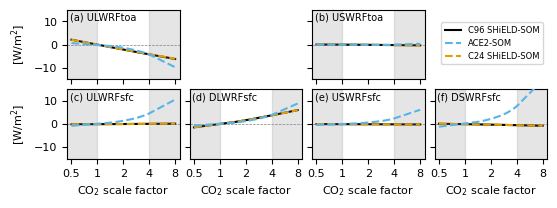

In [9]:
fig, axes = faceted.faceted(
    2,
    4,
    width=5.5,
    internal_pad=(0.1, 0.1),
    left_pad=0.6,
    bottom_pad=0.5,
    top_pad=0.1,
    right_pad=0.1,
)

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes


PANELS = {
    ax1: "ULWRFtoa",
    ax2: False,
    ax3: "USWRFtoa",
    ax4: False,
    ax5: "ULWRFsfc",
    ax6: "DLWRFsfc",
    ax7: "USWRFsfc",
    ax8: "DSWRFsfc",
}
COLORS = {
    REFERENCE: "black",
    ACE2_SOM: "C0",
    BASELINE: "C1",
}
LINE_STYLE = {
    REFERENCE: "-",
    BASELINE: "--",
    ACE2_SOM: "--",
}
LABELS = {REFERENCE: "C96 SHiELD-SOM", BASELINE: "C24 SHiELD-SOM", ACE2_SOM: "ACE2-SOM"}
ZORDER = {
    REFERENCE: 1,  # Start at 1 to allow for zero reference line at 0.
    BASELINE: 2,
    ACE2_SOM: 3,
}

for ax, name in PANELS.items():
    if name:
        for model, color in COLORS.items():
            delta_log_factor[name].sel(model=model).plot(
                ax=ax,
                color=color,
                label=LABELS[model],
                add_legend=False,
                ls=LINE_STYLE[model],
                zorder=ZORDER[model],
            )
    else:
        ax.set_visible(False)

for (ax, name), label in zip(
    PANELS.items(), ["a", None, "b", None, "c", "d", "e", "f"]
):
    if name:
        ax.axhline(0.0, color="gray", ls="--", lw=0.5, zorder=0)
        ax.annotate(
            f"({label}) {name}",
            xy=(0, 1),
            xytext=(2, -2),
            va="top",
            xycoords="axes fraction",
            textcoords="offset points",
            fontsize=7,
        )
        ax.set_ylabel("")
        ax.set_xticks(np.log(np.array([0.5, 1.0, 2.0, 4.0, 8.0])))
        ax.set_xticklabels(["0.5", "1", "2", "4", "8"])

        ax.set_title("")
        ax.axvspan(np.log(0.1), np.log(1.0), color="gray", alpha=0.2)
        ax.axvspan(np.log(4.0), np.log(10), color="gray", alpha=0.2)
        ax.set_ylim(-15, 15)

        # Set xlim such that gray areas are equal on either side 1 and 4.
        ax.set_xlim(np.log(4 / 9), np.log(9))

for ax in axes[4:]:
    ax.set_xlabel("CO$_2$ scale factor")

ax1.set_xlabel("")
ax3.set_xlabel("")

ax1.set_ylabel("[W/m$^2$]")
ax5.set_ylabel("[W/m$^2$]")
ax8.legend(
    fontsize=6,
    bbox_to_anchor=(1.0, 1.3),
    bbox_transform=ax8.transAxes,
    loc="lower right",
)

fig.savefig("figures/figure-10.png", dpi=200)
fig.savefig("figures/figure-10.pdf")